In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"
import csv
from ddpg_torch.ddpg_torch import Agent
import gym
import numpy as np
from lifting_rl.linkage_env import LinkageEnv
from scipy import interpolate
from livelossplot import PlotLosses
import matplotlib.pyplot as plt

In [2]:
params = {
    "N_LINKS": 5,
    "PARAM_VALS": np.array([9.81], dtype=np.float32),
    "OBS_LOW": np.array([0.5, 1, -0.5, -2.5, -2], dtype=np.float32),
    "OBS_HIGH": np.array([2.5, 3.1, 2.2, -0.3, -0.2], dtype=np.float32),
    "SPEED_LIMIT": 8,
    "ACT_LIMIT": 100,
    "TIME_STEP": 0.01,
    "VIDEO_FPS": 30,
}

In [3]:
def get_coordinates(path):
    coordinates = []
    with open(path) as fr:
        reader = csv.reader(fr)
        for idx, row in enumerate(reader):
            coordinates.append([float(i) for i in row])
    return np.array(coordinates)

In [4]:
def get_interpolated(coords, timestamps, mode="spline"):
    interpolated_coords = []
    for i in range(coords.shape[1]):
        if mode == "default":
            y = coords[:, i]
            f = interpolate.interp1d(timestamps, y)
        if mode == "spline":
            y = coords[:, i]

            def f(x, y=y):
                tck = interpolate.splrep(timestamps, y)
                return np.float32(interpolate.splev(x, tck))

        interpolated_coords.append(f)
    return interpolated_coords

In [5]:
path = "/home/mans/Documents/skeleton_angles.csv"
trajectory_points = get_coordinates(path)
num_frames = trajectory_points.shape[0]
trajectory_timestamps = np.array(
    [i * 1.0 / params["VIDEO_FPS"] for i in range(num_frames)]
)

time_step = params["TIME_STEP"]
end_time = round(num_frames / params["VIDEO_FPS"], 2)

interpolated_trajectory = get_interpolated(
    trajectory_points, trajectory_timestamps
)
timestamps = [
    np.float32(i * time_step)
    for i in range(int(end_time // time_step))
]

coordinates = np.array([
    [
        interpolated_trajectory[i](t)
        for i in range(len(interpolated_trajectory))
    ]
    for t in timestamps
], dtype=np.float32)

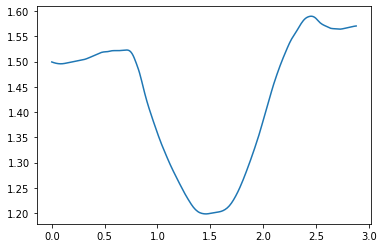

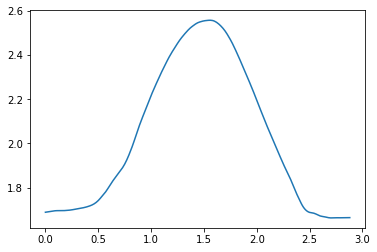

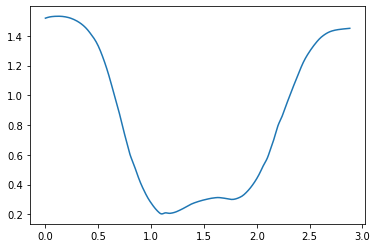

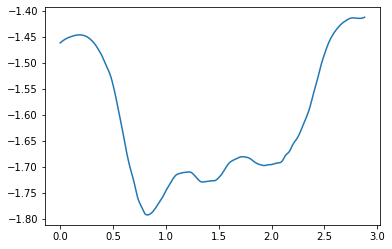

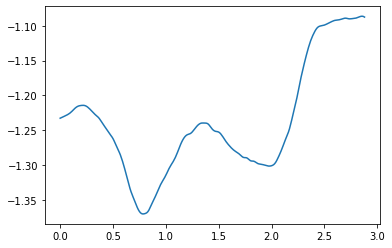

In [6]:
for i in range(5):
    plt.plot(timestamps, coordinates[:,i], '-')
    plt.show()

In [7]:
env = LinkageEnv(params, verbose=0)

KeyboardInterrupt: 

In [ ]:
agent = Agent(
    lr_actor=0.000025,
    lr_critic=0.00025,
    input_dims=[25],
    tau=0.001,
    env=env,
    batch_size=64,
    layer1_size=400,
    layer2_size=300,
    n_actions=5,
    chkpt_dir = "/home/mans/Documents/ddpg/1"
    
)

In [ ]:
agent.load_models()
zeros = np.zeros(5, dtype=np.float32)
step = 30
state = np.concatenate((coordinates[0], zeros))

states = [state]
gpos = coordinates[step]
i = 0
obs = env.inference_reset(state, gpos)    
while i < 289:
    done = False
    score = 0
    while not done:
        env.render()
        act = agent.inference_action(obs)
        new_state, reward, done, info = env.inference_step(act)
        states.append(new_state)
        score += reward
        obs = new_state
    i += step
    i = i if i <= 289 else 289
    gpos = coordinates[i]
    obs = env.inference_reset(new_state, gpos)    

env.close()